In [394]:
import numpy as np 
import matplotlib.pyplot as plt

In [395]:
# NORMALIZE DATA

def norm_input(input):
    nb_data, in_dim = np.shape(input)
    new_input = np.zeros([nb_data,in_dim])
    new_input[:,-1] = input[:,-1]
    
    for i in range(in_dim-1):
        d_min,d_max = np.min(input[:,i]),np.max(input[:,i])
        new_input[:,i] = (input[:,i]-d_min)/(d_max-d_min)
        
    return new_input   

# GET DATA - IRIS OR PIMA
def get_data(which,norm=True):
    if(which == 'iris'):
        raw_data = np.loadtxt("data/iris.data")
        nb_dat = np.shape(raw_data)[0]
        in_dim = np.shape(raw_data)[1] - 1
        out_dim = 3

        input = np.append(raw_data[:,:in_dim], -1.0*np.ones((nb_dat,1)), axis=1)

        targ = np.zeros((nb_dat,out_dim))
        for i in range(0,nb_dat):
            targ[i,int(raw_data[i,in_dim])] = 1.0
    elif(which == 'pima'):
        raw_data = np.loadtxt("data/pima-indians-diabetes.data")
        nb_dat = np.shape(raw_data)[0]
        in_dim = np.shape(raw_data)[1] - 1
        out_dim = 2

        input = np.append(raw_data[:,:in_dim], -1.0*np.ones((nb_dat,1)), axis=1)


        targ = np.zeros((nb_dat,out_dim))
        for i in range(0,nb_dat):
            targ[i,int(raw_data[i,in_dim])] = 1.0
            
            
    if(norm):
        input = norm_input(input)
    return input,targ



# DISPLAY CONFUSION MATRIX
def confmat(output, targ):
	######################### ##########################
	# Forward on an epoch and display a confusion matrix
	######################### ##########################
	
	#in_dim = np.shape(input)[1]
	out_dim = np.shape(targ)[1]

	nb_data = np.shape(input)[0]
	confmatrix = np.zeros((out_dim, out_dim))
	recall = np.zeros(out_dim)
	precis = np.zeros(out_dim)

	
	accu = 0.0
	count = 1
	
	for i in range(0, nb_data):
	
		#forward(input[i,:], output, weights)
		
		max_a = np.argmax(output[i,:])
		max_b = np.argmax(targ[i,:])

	
		confmatrix[max_b, max_a] += 1
		if(max_a == max_b):
			accu += 1
	
	for i in range(0,out_dim):
		recall[i] = 0
		precis[i] = 0
		for j in range(0,out_dim):
			recall[i] += confmatrix[i,j]
			precis[i] += confmatrix[j,i]
		
		if(recall[i] > 0.0):
			recall[i] = confmatrix[i,i] / recall[i] * 100.0
		
		if(precis[i] > 0.0):
			precis[i] = confmatrix[i,i] /precis[i] * 100.0
	
	print ("*****************************************************************")
	print ("Confmat :                                           Recall")
	for i in range(0,out_dim):
		print("         ", end="")
		for j in range(0,out_dim):
			print ("%10d"%confmatrix[i,j], end="")
		print("            %6.2f"%recall[i])
	print ("\n Precision  ", end="")
	for i in range(0,out_dim):
		print ("%10.2f"%precis[i], end="")
	print ("  Accu %8.2f%%"%(accu/nb_data*100.0))
	print ("\n*****************************************************************")
	

In [396]:
# ACTIVATION FUNCTION - SIGMOID

def sigmoid(beta=1):
    kk = lambda x: 1 / (1 + np.exp(-beta*x))
    return {'func':kk,'dfunc':lambda x: beta*x*(1-x),'beta':beta}


# CROSS ENTROPY LOSS

def cross_entropy_loss(y_pred, y_target):
    
    len_y = len(y_pred)
    
    ret = 0.0
    for  i in range(0,len(y_pred)):
        ret+= y_target[i]*np.log(y_pred[i])  
    ret = ret/len_y
    
    ret = -np.sum(ret)
    
    
    return ret


# FORWARD computation

def forward(input_vect, output_vect, weights,activation='sigmoid',beta=1):
    
    if(activation == 'sigmoid'):
        activation = sigmoid(beta)

    
    
    #Get the in_dim dimension from the vector dim
    in_dim = np.shape(input_vect)[1] 
	#Get the in_dim + 1 dimension from the vector dim
    out_dim = np.shape(output_vect)[1]
    
    #print(np.shape(input_vect),np.shape(weights))
    
    h = np.dot(input_vect,  weights)
    
    #print(np.shape(h))
    
    func = activation['func']
    output_vect = func(h) #activation function
            
    return output_vect

# BACKPROPRAGATION

def backward(input_vect, output_vect,hidden_vect, weights_1,weights_2, target_vect, learning_rate,d_act):
    #Get the in_dim dimension from the vector dim
    in_dim = np.shape(input_vect)[1] 
    #Get the in_dim + 1 dimension from the vector dim
    out_dim = np.shape(output_vect)[1]
    
    err_1 = output_vect - target_vect
    delta_out = err_1 * d_act(output_vect)
    delta_hidden = np.dot(delta_out,weights_2.T)*d_act(hidden_vect)
    
    
    delta_hidden[:,-1] = 0.0
    
    # weight updates
    weights_2_new = weights_2 - learning_rate * np.dot(hidden_vect.T,delta_out)
    weights_1_new = weights_1 - learning_rate * np.dot(input_vect.T,delta_hidden)
    
    
    return weights_1_new,weights_2_new


#MULTI BATCH SGD TRAINING OF NETWORK

def train(input_vect, target_vect, learning_rate=0.1, epochs=50,batches=1,hidden_dim=5,activation='sigmoid',beta=1):
    
    if(activation == 'sigmoid'):
        act = sigmoid(beta)
        
        
    losses = []
    
    
    #Get the in_dim dimension from the vector dim
    in_dim = np.shape(input_vect)[1] 
    #Get the in_dim + 1 dimension from the vector dim
    out_dim = np.shape(target_vect)[1]
    
    
    nb_data = np.shape(input_vect)[0]
    nb_batches = int(nb_data/batches)
    
    index = np.arange(0,nb_data)
    b_indexes = [index[i*nb_batches:min((i+1)*nb_batches,nb_data-1)] for i in range(batches)]
        
    
    weights_1 = np.random.rand(in_dim,hidden_dim+1)
    weights_2 = np.random.rand(hidden_dim+1,out_dim)
    
    
    for i in range(0,epochs):
        lss = []
        for j in range(0,batches):
            idx_batch = b_indexes[j]
            lenbatch = len(idx_batch)

            hidden_vect = np.zeros((lenbatch,hidden_dim+1))

            hidden_vect = forward(input_vect[idx_batch,:], hidden_vect, weights_1,activation=activation,beta=beta)
            hidden_vect= np.append(hidden_vect[:,:hidden_dim], -1.0*np.ones((lenbatch,1)), axis=1)

            
            output_vect = forward(hidden_vect, target_vect[idx_batch,:], weights_2,activation=activation,beta=beta)
            
            
            loss = cross_entropy_loss(output_vect, target_vect[idx_batch,:])
            lss.append(loss)
            
            
            
           # backprop
            weights_1,weights_2 = backward(input_vect[idx_batch,:], output_vect,hidden_vect, weights_1,weights_2, target_vect[idx_batch,:], learning_rate,act['dfunc']) 

        losses.append(np.mean(lss))
        
        
    return weights_1,weights_2,losses




def predict(input_vect, weights_1,weights_2,activation='sigmoid',beta=1):
    
    if(activation == 'sigmoid'):
        activation = sigmoid(beta)
    
    out_dim = np.shape(weights_2)[1]
    
    hidden_vect = np.zeros((1,np.shape(weights_1)[1]))
    hidden_vect = forward(input_vect, hidden_vect, weights_1,activation=activation,beta=beta)
    hidden_vect= np.append(hidden_vect[:,:np.shape(weights_1)[1]-1], -1.0*np.ones((len(input_vect),1)), axis=1)
    
    output_vect = np.zeros((1,out_dim))
    output_vect = forward(hidden_vect, output_vect, weights_2,activation=activation,beta=beta)
    
    return output_vect

# NN applied in different datasets

loss_trend:  0.0694
*****************************************************************
Confmat :                                           Recall
                 50         0         0            100.00
                  0        47         3             94.00
                  0         1        49             98.00

 Precision      100.00     97.92     94.23  Accu    97.33%

*****************************************************************


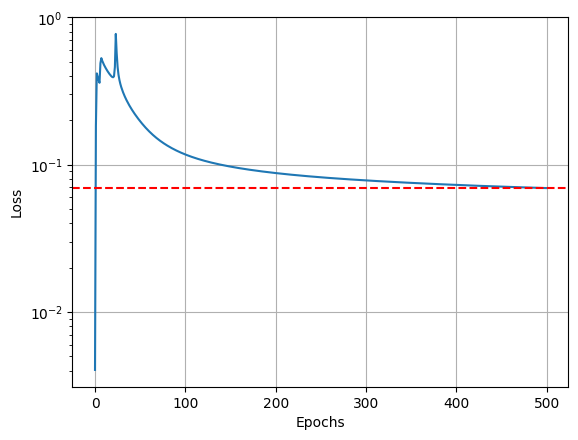

In [406]:
which_data = 'iris'
bb = 2
input,targ = get_data(which_data,norm=True)
w1,w2,lss = train(input,targ,learning_rate=0.05,epochs=500,batches=10,hidden_dim=15,activation='sigmoid',beta=bb)
ypreds = predict(input,w1,w2,activation='sigmoid',beta=bb)
xx_plot = np.arange(0,len(lss))
loss_trend = np.mean(lss[-5:])
print('loss_trend: ',round(loss_trend,4))

plt.plot(xx_plot,lss)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.yscale('log')
plt.axhline(y=loss_trend, color='r', linestyle='--')
confmat(ypreds,targ)

loss_trend:  0.4554
*****************************************************************
Confmat :                                           Recall
                423        77             84.60
                 73       195             72.76

 Precision       85.28     71.69  Accu    80.47%

*****************************************************************


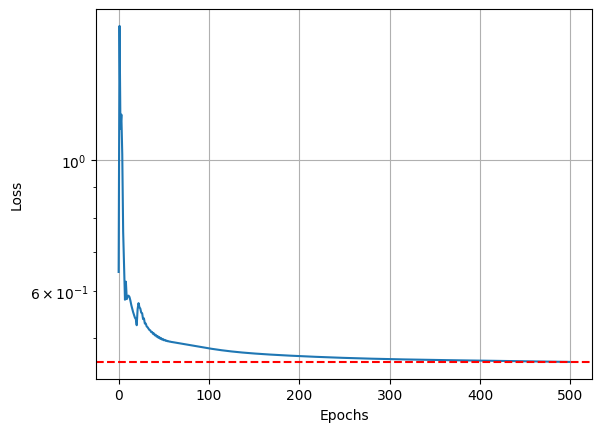

In [405]:
which_data = 'pima'
bb = 2
input,targ = get_data(which_data,norm=True)
w1,w2,lss = train(input,targ,learning_rate=0.03,epochs=500,batches=10,hidden_dim=10,activation='sigmoid',beta=bb)
ypreds = predict(input,w1,w2,activation='sigmoid',beta=bb)
xx_plot = np.arange(0,len(lss))
loss_trend = np.mean(lss[-5:])
print('loss_trend: ',round(loss_trend,4))

plt.plot(xx_plot,lss)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.yscale('log')
plt.axhline(y=loss_trend, color='r', linestyle='--')
confmat(ypreds,targ)